# Quantum Fourier Transform Benchmark

In [1]:
low = 1
high = 28
samples = 100

In [2]:
import time
import random
import math
import numpy as np

## FFTW ("Classical" DFT)

In [3]:
# See https://blog.hpc.qmul.ac.uk/pyfftw.html
import pyfftw

pyfftw.interfaces.cache.enable()
pyfftw.interfaces.cache.set_keepalive_time(60)
total_time = 0

fftw_results = {}
for n in range(low, high + 1):
    width_results = []
    for i in range(samples):
        io_array = pyfftw.empty_aligned(2**n, dtype=np.complex64)
        io_array[0] = 1.
        start = time.perf_counter()
        pyfftw.interfaces.numpy_fft.fft(io_array, overwrite_input=True, threads = (16 if (n > 18) else 1))
        width_results.append(time.perf_counter() - start)

    fftw_results[n] = sum(width_results) / samples

print(fftw_results)

{1: 1.4487779953924473e-05, 2: 1.1225279849895742e-05, 3: 1.112739002564922e-05, 4: 1.1930129621759989e-05, 5: 1.179100992885651e-05, 6: 1.1852310017275158e-05, 7: 1.422975015884731e-05, 8: 1.2457080083549954e-05, 9: 1.4152390249364544e-05, 10: 1.3974129869893658e-05, 11: 1.6803919897938613e-05, 12: 2.4933670028985945e-05, 13: 4.370427999674575e-05, 14: 8.441519988991786e-05, 15: 0.00016227515017817496, 16: 0.0003398100300182705, 17: 0.0007195705597405322, 18: 0.0017200201298328466, 19: 0.03797772589998203, 20: 0.037827528540110504, 21: 0.042026457109896, 22: 0.05788169929990545, 23: 0.08142864819994429, 24: 0.13241157140008, 25: 0.23633014491013454, 26: 0.4459775614300452, 27: 0.8888114376999511, 28: 2.0915239195198954}


## PyQrack

In [4]:
%env QRACK_QUNITMULTI_DEVICES 1
from pyqrack import QrackSimulator, Pauli

def reverse_qrack(sim):
    start = 0
    end = sim.num_qubits() - 1
    while (start < end):
        sim.swap(start, end)
        start += 1
        end -= 1

env: QRACK_QUNITMULTI_DEVICES=1


### |0> initialization

In [5]:
def bench_qrack_0(n):
    sim = QrackSimulator(n, isOpenCL=False)
    # Permutation basis eigenstate initialization before QFT is "trivial" for Qrack.
    start = time.perf_counter()
    qubits = [i for i in range(n)]
    sim.qft(qubits)
    reverse_qrack(sim)
    sim.m_all()

    return time.perf_counter() - start

qrack_0_results = {}
for n in range(low, high + 1):
    width_results = []
        
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_qrack_0(n))

    qrack_0_results[n] = sum(width_results) / samples

print(qrack_0_results)

{1: 8.832889870973303e-06, 2: 8.909880016290117e-06, 3: 1.010917992971372e-05, 4: 1.3022710008954164e-05, 5: 1.5099280317372176e-05, 6: 1.7476490284025205e-05, 7: 1.961004993063398e-05, 8: 2.1567179792327807e-05, 9: 2.4205160079873168e-05, 10: 2.7112239731650334e-05, 11: 3.0341550082084724e-05, 12: 3.250793004553998e-05, 13: 3.602183987823082e-05, 14: 3.923629999917466e-05, 15: 4.084469004737912e-05, 16: 4.484410997974919e-05, 17: 4.932828971504932e-05, 18: 5.236663997493452e-05, 19: 5.605666035989998e-05, 20: 6.0558330005733296e-05, 21: 6.256900018343003e-05, 22: 6.719179003994213e-05, 23: 7.175258011557161e-05, 24: 7.58658601262141e-05, 25: 7.964471991726896e-05, 26: 8.329875010531395e-05, 27: 8.751833011046983e-05, 28: 9.296495005401084e-05}


### Random 1-qubit unitary initialization

In [6]:
def bench_qrack(n):
    sim = QrackSimulator(n)
    # Permutation basis eigenstate initialization before QFT is "trivial" for Qrack,
    # so we give it a realistic case instead.
    for i in range(n):
        # Initialize with uniformly random single qubit gates, across full width.
        sim.u(i, random.uniform(0, 4 * math.pi), random.uniform(0, 4 * math.pi), random.uniform(0, 4 * math.pi))
    start = time.perf_counter()
    qubits = [i for i in range(n)]
    sim.qft(qubits)
    reverse_qrack(sim)
    sim.m_all()

    return time.perf_counter() - start

qrack_results = {}
for n in range(low, high + 1):
    width_results = []
        
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_qrack(n))

    qrack_results[n] = sum(width_results) / samples

print(qrack_results)

Device #0, Loaded binary from: /home/iamu/.qrack/qrack_ocl_dev_Intel(R)_UHD_Graphics_[0x9bc4].ir
Device #1, Loaded binary from: /home/iamu/.qrack/qrack_ocl_dev_NVIDIA_GeForce_RTX_3080_Laptop_GPU.ir
{1: 6.082220097596291e-06, 2: 5.1345559877518096e-05, 3: 0.0001400804001968936, 4: 0.00019095126994216115, 5: 0.00021485448007297237, 6: 0.00028406771987647515, 7: 0.00037905708002654136, 8: 0.00047254892000637484, 9: 0.0006141179499900318, 10: 0.0008539177001875941, 11: 0.0014518216800206575, 12: 0.0020167860501533142, 13: 0.0024668975899476207, 14: 0.0029504735598311527, 15: 0.0035224460802055547, 16: 0.003908150099996419, 17: 0.004318875770077284, 18: 0.004988845920051972, 19: 0.005852856899909966, 20: 0.007809466710059496, 21: 0.011032729849976022, 22: 0.016287069309873912, 23: 0.02724983282994799, 24: 0.0489351472501221, 25: 0.09063340156979394, 26: 0.17576898746021472, 27: 0.34974434160008966, 28: 0.6895683888402345}


### GHZ state initialization

In [7]:
def bench_qrack(n):
    sim = QrackSimulator(n)
    sim.h(0)
    for i in range(n - 1):
        sim.mcx([i], i + 1)
    start = time.perf_counter()
    qubits = [i for i in range(n)]
    sim.qft(qubits)
    reverse_qrack(sim)
    sim.m_all()

    return time.perf_counter() - start

qrack_k_results = {}
for n in range(low, high + 1):
    width_results = []
        
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_qrack(n))

    qrack_k_results[n] = sum(width_results) / samples

print(qrack_k_results)

{1: 1.2652169934881386e-05, 2: 5.442862970085116e-05, 3: 0.00016627245022391435, 4: 0.00039181447009468685, 5: 0.0005078439101635013, 6: 0.0007088222898892127, 7: 0.0009579663501790492, 8: 0.0013866258999769344, 9: 0.0023088574000212246, 10: 0.004430749009952706, 11: 0.010400313210011518, 12: 0.012150970789843996, 13: 0.014271853969985386, 14: 0.016549214740043682, 15: 0.018938619980144723, 16: 0.02164239059002284, 17: 0.024279068119794828, 18: 0.026590839830205368, 19: 0.030571144499990623, 20: 0.03639047906999622, 21: 0.046422809180039624, 22: 0.06428546676994301, 23: 0.09758870673020283, 24: 0.16139035713000338, 25: 0.2865589992100286, 26: 0.5644936139901255, 27: 1.1168704893799442, 28: 2.151604727469967}


## Qiskit Aer

In [8]:
from qiskit import QuantumCircuit
from qiskit import execute, Aer
from qiskit.providers.aer import QasmSimulator

def reverse_aer(num_qubits, circ):
    start = 0
    end = num_qubits - 1
    while (start < end):
        circ.swap(start, end)
        start += 1
        end -= 1

# Implementation of the Quantum Fourier Transform
def aer_qft(num_qubits, circ):
    # Quantum Fourier Transform
    for j in range(num_qubits):
        for k in range(j):
            circ.cp(math.pi/float(2**(j-k)), j, k)
        circ.h(j)
    reverse_aer(num_qubits, circ)
    for j in range(num_qubits):
        circ.measure(j, j)

    return circ

sim_backend = QasmSimulator(shots=1, method='statevector_gpu')

def bench_aer(num_qubits):
    circ = QuantumCircuit(num_qubits, num_qubits)
    aer_qft(num_qubits, circ)
    start = time.perf_counter()
    job = execute([circ], sim_backend, timeout=600)
    result = job.result()
    return time.perf_counter() - start

aer_results = {}
for n in range(low, high + 1):
    width_results = []
        
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_aer(n))

    aer_results[n] = sum(width_results) / samples

print(aer_results)

{1: 0.003055091449932661, 2: 0.0036386238897466684, 3: 0.00439768839001772, 4: 0.005333070619963109, 5: 0.0064799220801432965, 6: 0.0071724601897949465, 7: 0.00817154488988308, 8: 0.009102134940148972, 9: 0.009819214720009769, 10: 0.010861938299967733, 11: 0.011978838630056998, 12: 0.013315118329956022, 13: 0.015255210370196438, 14: 0.01578480595988367, 15: 0.018234806370055593, 16: 0.019158277599963185, 17: 0.021199987760192017, 18: 0.022992942629825847, 19: 0.029141720310108213, 20: 0.03603848872007802, 21: 0.04641013059001125, 22: 0.06826563748996704, 23: 0.11869133918975422, 24: 0.21893384100992988, 25: 0.4161273124298168, 26: 0.8495769403000668, 27: 1.7236150698396886, 28: 3.585245427579939}


## Qulacs

In [9]:
import qulacs

def reverse_qulacs(num_qubits, circ):
    start = 0
    end = num_qubits - 1
    while (start < end):
        circ.add_gate(qulacs.gate.SWAP(start, end))
        start += 1
        end -= 1

def get_rotz(exponent: float) -> np.ndarray:
    return np.diag([1., np.exp(1.j * np.pi * exponent)])

def bench_qulacs(n):
    sim = qulacs.QuantumStateGpu(n)
    circ = qulacs.QuantumCircuit(n)
    start = time.perf_counter()

    for j in range(n):
        for k in range(j):
            mat = get_rotz(math.pi/float(2**(j-k)))
            gate = qulacs.gate.DenseMatrix(k, mat)
            gate.add_control_qubit(j, 1)
            circ.add_gate(gate)
        circ.add_gate(qulacs.gate.H(j))
    reverse_qulacs(n, circ)
    for index in range(n):
        circ.add_gate(qulacs.gate.Measurement(index, index))

    circ.update_quantum_state(sim)

    return time.perf_counter() - start

qulacs_results = {}
for n in range(low, high + 1):
    width_results = []
        
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_qulacs(n))

    qulacs_results[n] = sum(width_results) / samples

print(qulacs_results)

{1: 0.0001545822998014046, 2: 0.0003243771900088177, 3: 0.000452304880018346, 4: 0.0006086408900591778, 5: 0.0007179251498382655, 6: 0.0008727093199195223, 7: 0.0010168690099817469, 8: 0.0012425124502624385, 9: 0.0014876308001112192, 10: 0.0018208665600468522, 11: 0.0021949497000241535, 12: 0.0027915836900501744, 13: 0.0033340945203235604, 14: 0.0038483048302077804, 15: 0.004282848159928108, 16: 0.006673487100051716, 17: 0.010854072490183171, 18: 0.015049415479988965, 19: 0.023434755860180304, 20: 0.043037192650190265, 21: 0.08379739621992485, 22: 0.16577553672006615, 23: 0.340104670289802, 24: 0.665085723450029, 25: 1.3472865139599162, 26: 2.739395671619968, 27: 5.698878435280385, 28: 11.844527647899776}


## QCGPU

In [10]:
%env PYOPENCL_CTX 1

env: PYOPENCL_CTX=1


In [11]:
import qcgpu

def swap_qcgpu(circ, q1, q2):
    circ.cx(q1, q2)
    circ.cx(q2, q1)
    circ.cx(q1, q2)
    
def reverse_qcgpu(num_qubits, circ):
    start = 0
    end = num_qubits - 1
    while (start < end):
        swap_qcgpu(circ, start, end)
        start += 1
        end -= 1

def bench_qcgpu(num_qubits):
    state = qcgpu.State(num_qubits)
    start = time.perf_counter()
 
    for j in range(num_qubits):
        for k in range(j):
            state.cu1(j, k, math.pi/float(2**(j-k)))
        state.h(j)
    reverse_qcgpu(num_qubits, state)
    state.measure()

    state.backend.queue.finish()
    return time.perf_counter() - start

qcgpu_results = {}
for n in range(low, high + 1):
    width_results = []
         
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_qcgpu(n))

    qcgpu_results[n] = sum(width_results) / samples

print(qcgpu_results)

{1: 0.000683993200182158, 2: 0.0017102807798801223, 3: 0.001992649410240119, 4: 0.0029757126900585716, 5: 0.003973956270237977, 6: 0.005450289840082405, 7: 0.006808730020275107, 8: 0.008788024019995646, 9: 0.010546463430036965, 10: 0.013073897719805246, 11: 0.015252532490048907, 12: 0.018239381880121072, 13: 0.020979751069935448, 14: 0.024436445000246748, 15: 0.02764184098010446, 16: 0.03171245580000687, 17: 0.03563335367005493, 18: 0.04107788192985026, 19: 0.04778596887990716, 20: 0.0593734560201483, 21: 0.07486231622977357, 22: 0.10051203029008321, 23: 0.16658398592011509, 24: 0.34299687094986436, 25: 0.7050074645700807, 26: 1.51659464556029, 27: 3.076065099109801, 28: 6.358172332299837}


## Results

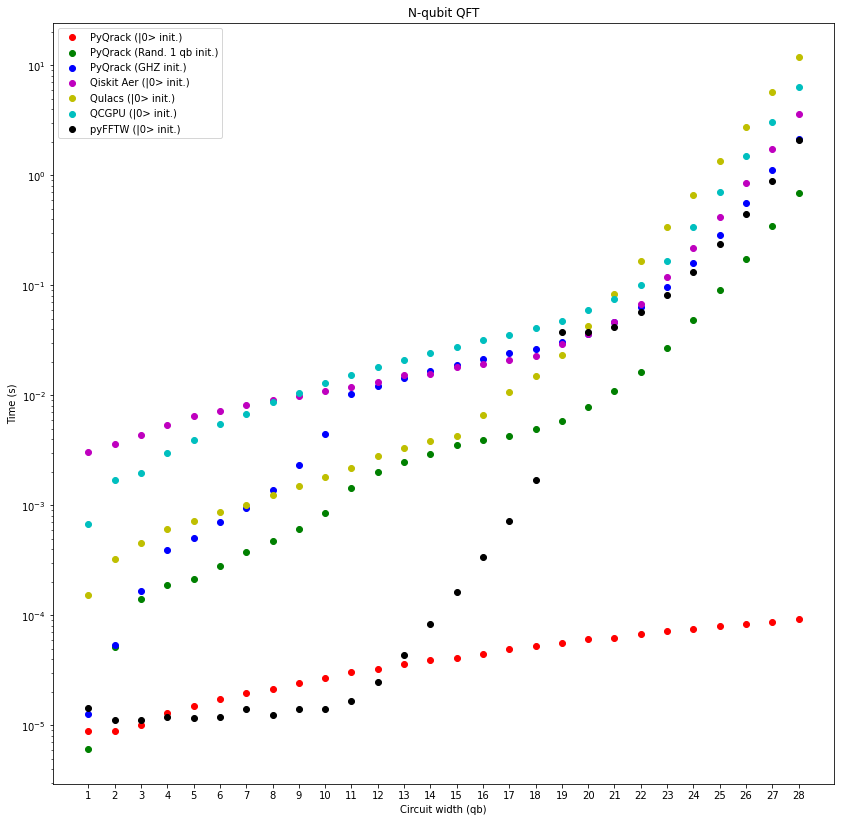

In [12]:
import matplotlib.pyplot as plt

fig = plt.gcf()
fig.set_size_inches(14, 14)

colors = list("kcymbgr")

x = qrack_0_results.keys()
y = qrack_0_results.values()
plt.scatter(x,y,color=colors.pop())

x = qrack_results.keys()
y = qrack_results.values()
plt.scatter(x,y,color=colors.pop())

x = qrack_k_results.keys()
y = qrack_k_results.values()
plt.scatter(x,y,color=colors.pop())

x = aer_results.keys()
y = aer_results.values()
plt.scatter(x,y,color=colors.pop())

x = qulacs_results.keys()
y = qulacs_results.values()
plt.scatter(x,y,color=colors.pop())

x = qcgpu_results.keys()
y = qcgpu_results.values()
plt.scatter(x,y,color=colors.pop())

x = fftw_results.keys()
y = fftw_results.values()
plt.scatter(x,y,color=colors.pop())

plt.title("N-qubit QFT")
plt.xlabel("Circuit width (qb)")
plt.ylabel("Time (s)")
plt.legend(["PyQrack (|0> init.)", "PyQrack (Rand. 1 qb init.)", "PyQrack (GHZ init.)", "Qiskit Aer (|0> init.)", "Qulacs (|0> init.)", "QCGPU (|0> init.)", "pyFFTW (|0> init.)"])
plt.yscale("log")
plt.xticks(np.arange(low, high + 1, step=1))

plt.show()

fig.savefig('qft_chart.png', dpi=100)

In [13]:
import platform

print(platform.machine())
print(platform.version())
print(platform.platform())
print(platform.uname())
print(platform.system())
print(platform.processor())

x86_64
#33~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Mon Jan 30 17:03:34 UTC 2
Linux-5.19.0-32-generic-x86_64-with-glibc2.35
uname_result(system='Linux', node='sekhmet', release='5.19.0-32-generic', version='#33~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Mon Jan 30 17:03:34 UTC 2', machine='x86_64')
Linux
x86_64


In [14]:
import subprocess

line_as_bytes = subprocess.check_output("nvidia-smi -L", shell=True)
line = line_as_bytes.decode("ascii")
_, line = line.split(":", 1)
line, _ = line.split("(")
print(line.strip())

NVIDIA GeForce RTX 3080 Laptop GPU


In [15]:
import cpuinfo
cpuinfo.get_cpu_info()['brand_raw']

'Intel(R) Core(TM) i9-10980HK CPU @ 2.40GHz'